In [49]:
import pandas as pd
import numpy as np

In [50]:
import sys
sys.path.insert(0, '/home/tegbe/2023/ccl/timeRobert/')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory

from eda import exp

In [51]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]


# Rename columns to generic names
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})

df_pdoil_clean = df_pdoil.dropna(axis=0)

# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil_clean, 'ds', 'y', '1999-01-01')

df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)

In [52]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [53]:
import matplotlib.pyplot as plt


def create_windows(train_data, window_size=3):
    X, y = [], []
    for i in range(len(train_data) - window_size):
        window = train_data[i:(i + window_size)]
        X.append(window)
        y.append(train_data[i + window_size])
    return np.array(X), np.array(y)


def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(ds, y_test, label='Actual', color='b', marker='o')
    plt.plot(ds, y_forecast, label='Random Forest Forecast', color='r', marker='d')
    # Use xgb_forecast for XGBoost or any other forecast
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()
    
    
# import matplotlib.pyplot as plt

# def plot_forecast(y_test, y_forecast):
#     # Plotting actual vs predicted values
#     plt.figure(figsize=(8, 6))
#     plt.plot(y_test, label='Actual', marker='o')
#     plt.plot(y_forecast, label='Random Forest Forecast', marker='x')
#     # Use xgb_forecast for XGBoost or any other forecast
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title('Actual vs Predicted Values')
#     plt.legend()
#     plt.show()

In [54]:


# Splitting train data into input windows and output
X_train_windows, y_train_windows = create_windows(y_train.values)
X_test_windows, y_test_windows = create_windows(y_test.values)

# Perform splits on the date columns as well
_, ds_train_windows = create_windows(X_train.values)
_, ds_test_windows = create_windows(X_test.values)

In [55]:
y_train_windows.shape, ds_train_windows.flatten().shape

((244,), (244,))

In [56]:
# Initialize Random Forest and XGBoost models
rf_model = RandomForestRegressor()

# Fit Random Forest and XGBoost models on the input windows and output
rf_model.fit(X_train_windows, y_train_windows)

rf_forecast = rf_model.predict(X_test_windows)
rf_mape = mean_absolute_percentage_error(y_test_windows, rf_forecast)
print("Random Forest MAPE:", rf_mape)


Random Forest MAPE: 0.2196175081638693


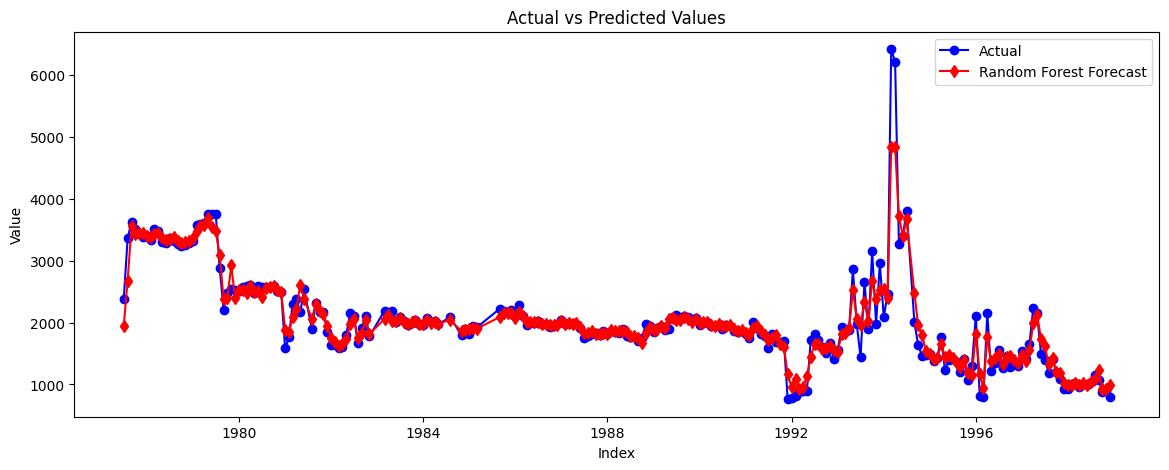

In [57]:
rf_train_forecast = rf_model.predict(X_train_windows)
plot_forecast(y_train_windows, rf_train_forecast, ds_train_windows.flatten())

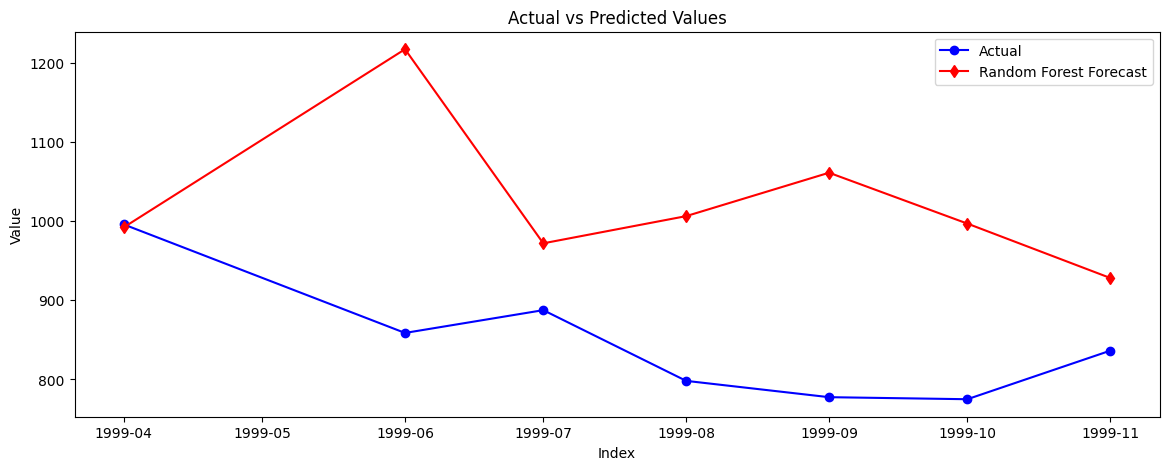

In [58]:
plot_forecast(y_test_windows, rf_forecast, ds_test_windows.flatten())

## XGBOOST MODEL

In [59]:

xgb_model = XGBRegressor()

xgb_model.fit(X_train_windows, y_train_windows)

xgb_forecast = xgb_model.predict(X_test_windows)
xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
print("XGBoost MAPE:", xgb_mape)


XGBoost MAPE: 0.16404454799279208


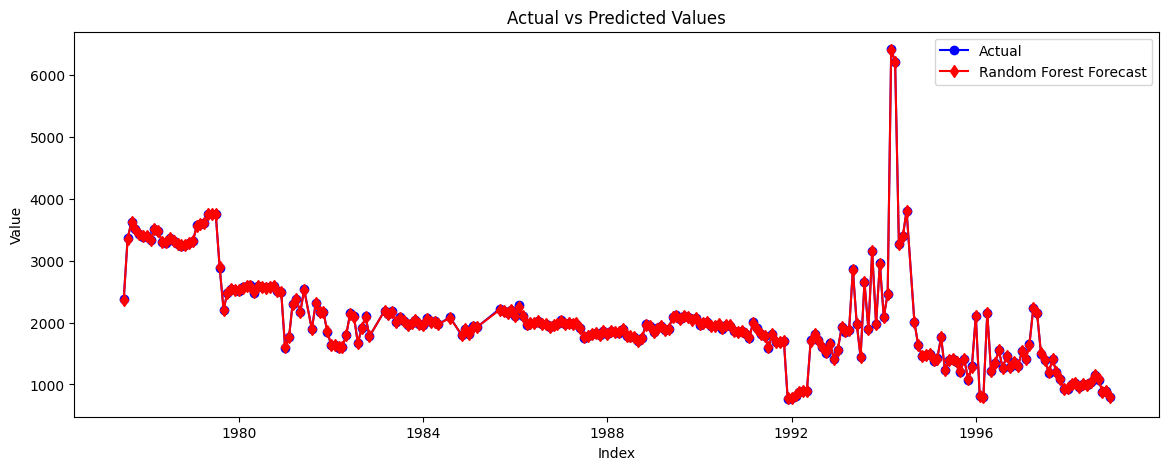

In [60]:
xgb_train_forecast = xgb_model.predict(X_train_windows)
plot_forecast(y_train_windows, xgb_train_forecast, ds_train_windows.flatten())

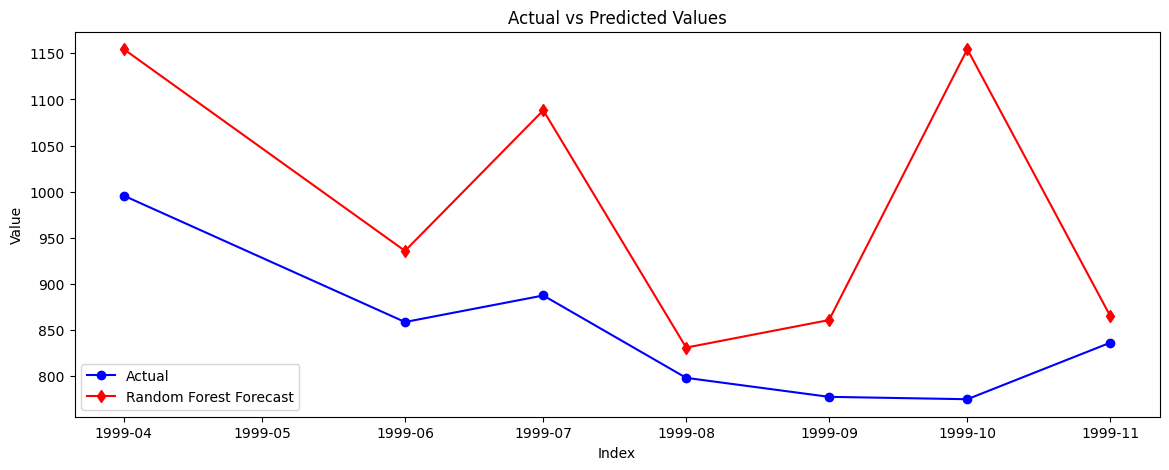

In [61]:
plot_forecast(y_test_windows, xgb_forecast, ds_test_windows.flatten())

In [118]:
y_test.shape, y_test_windows.shape

((10,), (7,))

In [62]:
xgb_test_forecast = xgb_model.predict(X_test_windows)

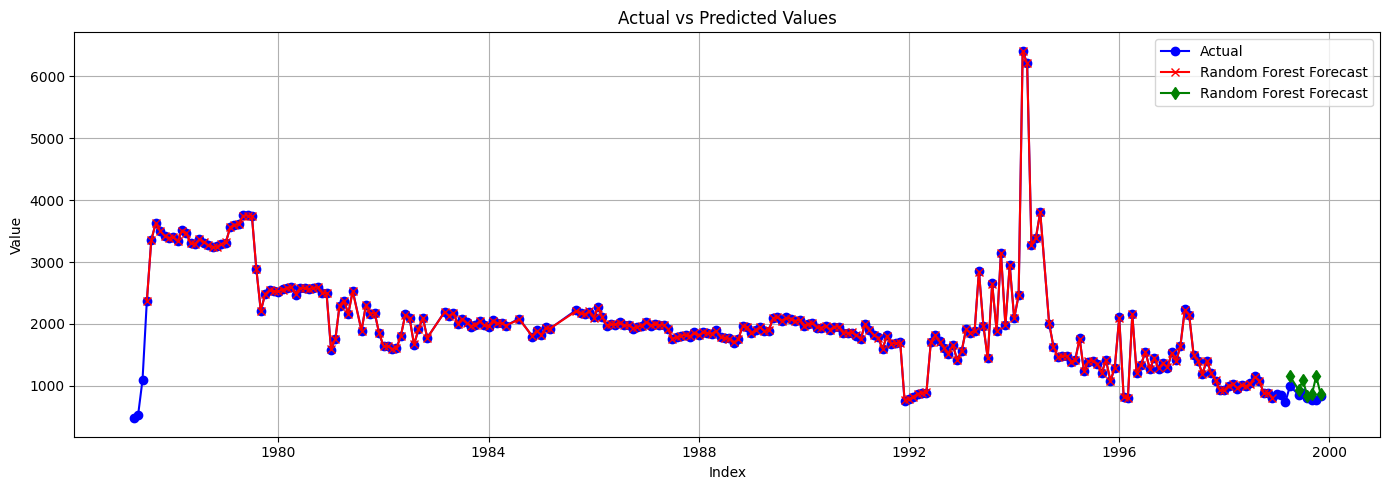

In [63]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Actual', marker='o')
plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(ds_test_windows.flatten(), xgb_test_forecast, color='g', label='Random Forest Forecast', marker='d')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter search with xgboost

In [32]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Define the parameter grid for XGBoost
xgb_params_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = ParameterGrid(xgb_params_grid)
cnt = 0
for p in xgb_grid:
    cnt += 1

print('Total Possible Models for XGBoost:', cnt)

xgb_model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])  # Ensure it's explicitly a DataFrame

# Your loop for XGBoost hyperparameter search
for p in xgb_grid:
    xgb_model = XGBRegressor(
        n_estimators=p['n_estimators'],
        max_depth=p['max_depth'],
        learning_rate=p['learning_rate'],
        # subsample=p['subsample'],
        # colsample_bytree=p['colsample_bytree']
    )
    
    xgb_model.fit(X_train_windows, y_train_windows)
    xgb_forecast = xgb_model.predict(X_test_windows)
    
    xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
    
    xgb_model_parameters = pd.concat([xgb_model_parameters, pd.DataFrame({'MAPE': [xgb_mape], 'Parameters': [p]})], ignore_index=True)


Total Possible Models for XGBoost: 27


/tmp/ipykernel_2214/2713081287.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xgb_model_parameters = pd.concat([xgb_model_parameters, pd.DataFrame({'MAPE': [xgb_mape], 'Parameters': [p]})], ignore_index=True)


In [33]:
parameters = xgb_model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.129170,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
1,0.129222,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
2,0.130690,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
3,0.133776,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
4,0.135226,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


In [34]:
parameters['Parameters'].iloc[0]

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}

In [64]:

xgb_model_best = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300
)

xgb_model_best.fit(X_train_windows, y_train_windows)

xgb_forecast = xgb_model_best.predict(X_test_windows)
xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
print("XGBoost MAPE:", xgb_mape)


XGBoost MAPE: 0.1291701549023919


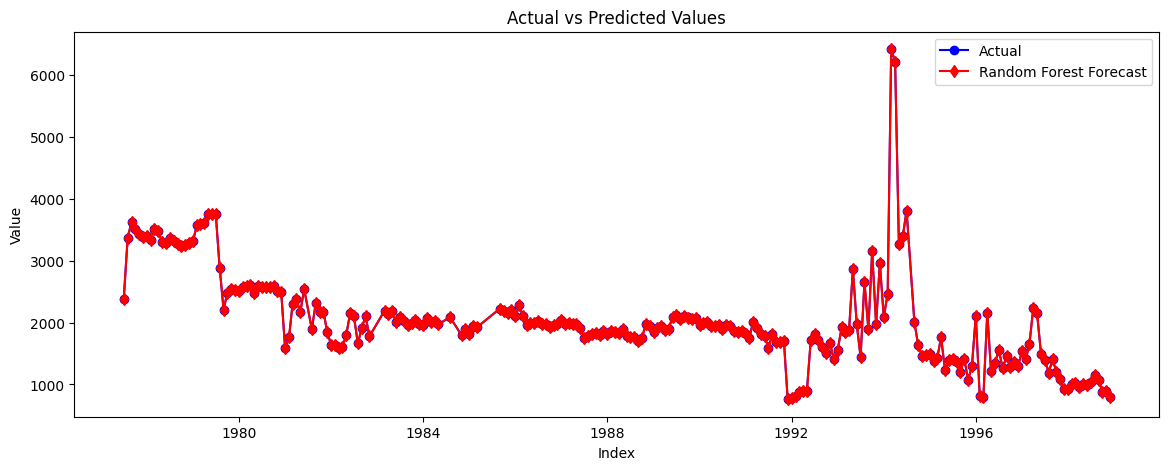

In [65]:
xgb_train_forecast = xgb_model_best.predict(X_train_windows)
plot_forecast(y_train_windows, xgb_train_forecast, ds_train_windows.flatten())

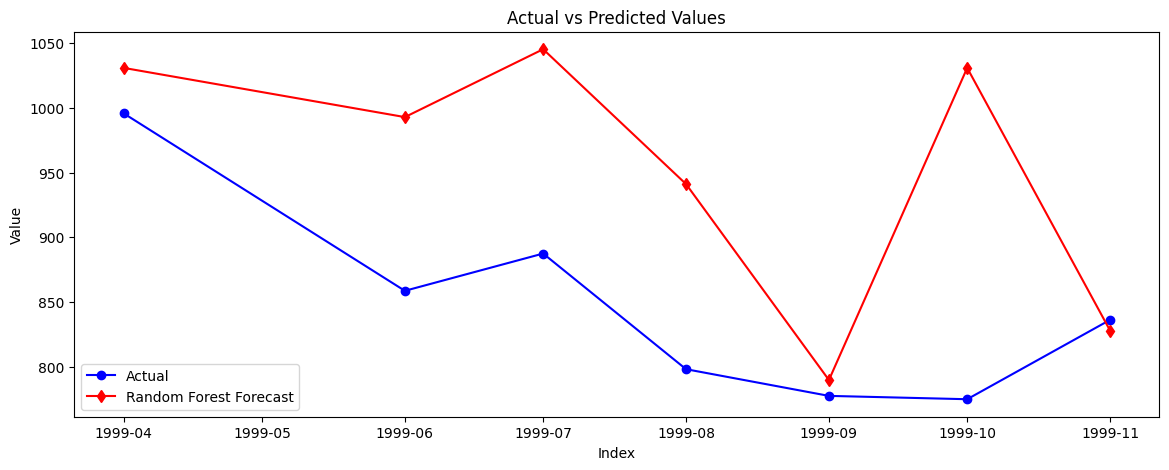

In [66]:
plot_forecast(y_test_windows, xgb_forecast, ds_test_windows.flatten())

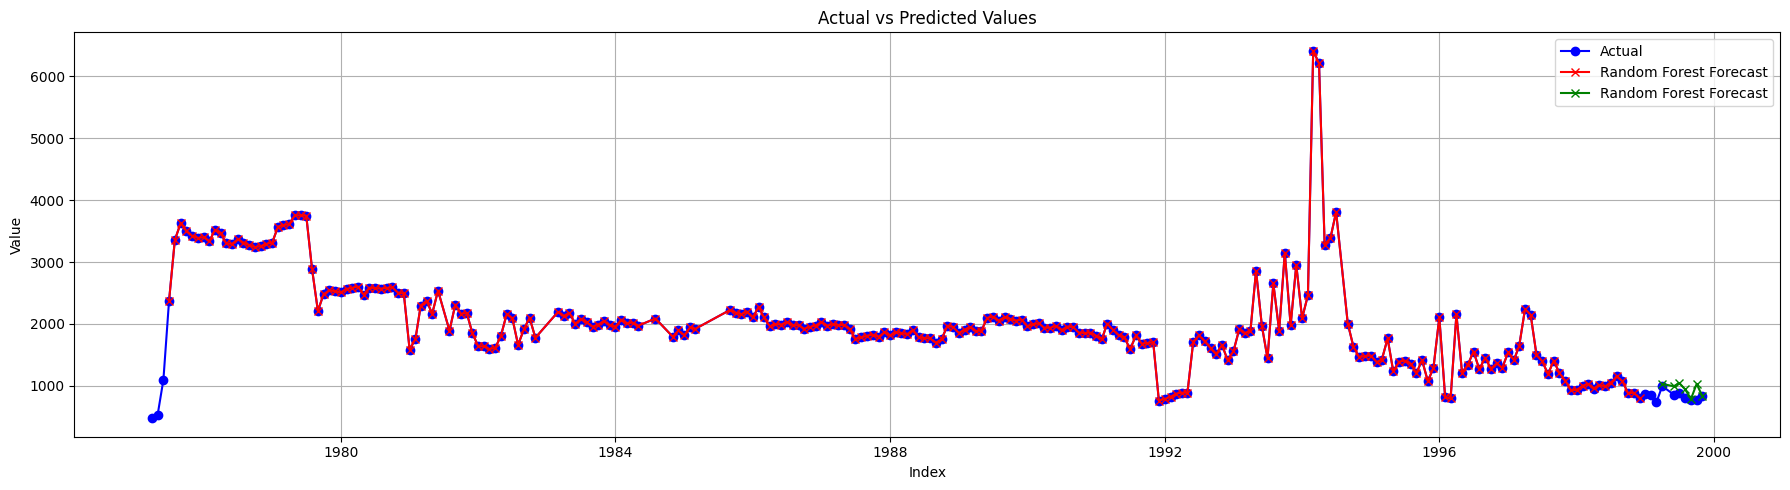

In [71]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(18, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Actual', marker='o')
plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(ds_test_windows.flatten(), xgb_forecast, color='g', label='Random Forest Forecast', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
X_train[:5], y_train[:5]

(          ds
 0 1977-04-01
 1 1977-05-01
 2 1977-06-01
 3 1977-07-01
 4 1977-08-01,
 0     474.600000
 1     524.761905
 2    1096.793103
 3    2372.233010
 4    3357.987013
 Name: y, dtype: float64)

In [77]:
import pandas as pd

# Assuming X_train contains the latest timestamp
latest_timestamp = X_train['ds'].max()

# Generate future timestamps (e.g., forecasting for the next 5 days)
future_timestamps = pd.date_range(start=latest_timestamp, periods=5, freq='M')
future_timestamps

DatetimeIndex(['1998-12-31', '1999-01-31', '1999-02-28', '1999-03-31',
               '1999-04-30'],
              dtype='datetime64[ns]', freq='M')

In [93]:
window = X_train_windows[-1] 
window.reshape(1, -1).shape

(1, 3)

In [114]:
forecast = []
window = X_train_windows[-1].reshape(1, -1)

for i in range(5):
    prediction = xgb_model_best.predict(window)
    forecast.append(prediction[0])
    np.append(np.array([[1075.42266667,  882.30612903,  887.8943128 ]]).flatten()[1:], prediction).reshape(1, -1)

In [115]:
forecast

[800.88165, 800.88165, 800.88165, 800.88165, 800.88165]

In [113]:
prediction = xgb_model_best.predict(window.reshape(1, -1))
prediction[0]

800.88165

In [112]:
np.append(np.array([[1075.42266667,  882.30612903,  887.8943128 ]]).flatten()[1:], prediction).reshape(1, -1)

array([[882.30612903, 887.8943128 , 800.88165283]])

array([800.88165], dtype=float32)

In [124]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


In [130]:
latest_timestamp = X_test['ds'].iloc[-1]
latest_timestamp

Timestamp('1999-11-01 00:00:00')

In [131]:
pd.date_range(start=latest_timestamp, periods=12, freq='M')  # Your desired future timestamps

DatetimeIndex(['1999-11-30', '1999-12-31', '2000-01-31', '2000-02-29',
               '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30',
               '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31'],
              dtype='datetime64[ns]', freq='M')

In [155]:
# Initialize a list to store forecasted values
forecast = []

# Initialize the initial window for the XGBoost model
window = X_test_windows[-1].reshape(1, -1)  # Assuming window_size is defined

# Generate future timestamps for forecasting
PERIODS=36
latest_timestamp = X_test['ds'].iloc[-1]
future_timestamps = pd.date_range(start=latest_timestamp, periods=PERIODS, freq='M')  # Your desired future timestamps

# Iterate through future timestamps
for timestamp in future_timestamps:
    # Use the current window to predict the next value
    prediction = xgb_model_best.predict(window)  # Reshape the window as needed
    
    # Append the prediction to the forecast
    forecast.append(prediction[0])
    
    # Update the window by removing the oldest value and adding the latest prediction
    window = np.append(window.flatten()[1:], prediction).reshape(1, -1)

# Create a DataFrame with the forecasted values and their corresponding timestamps
forecast_df = pd.DataFrame({'ds': future_timestamps, 'yhat': forecast})

future_forcast = forecast_df['yhat']
future_ds = forecast_df['ds']

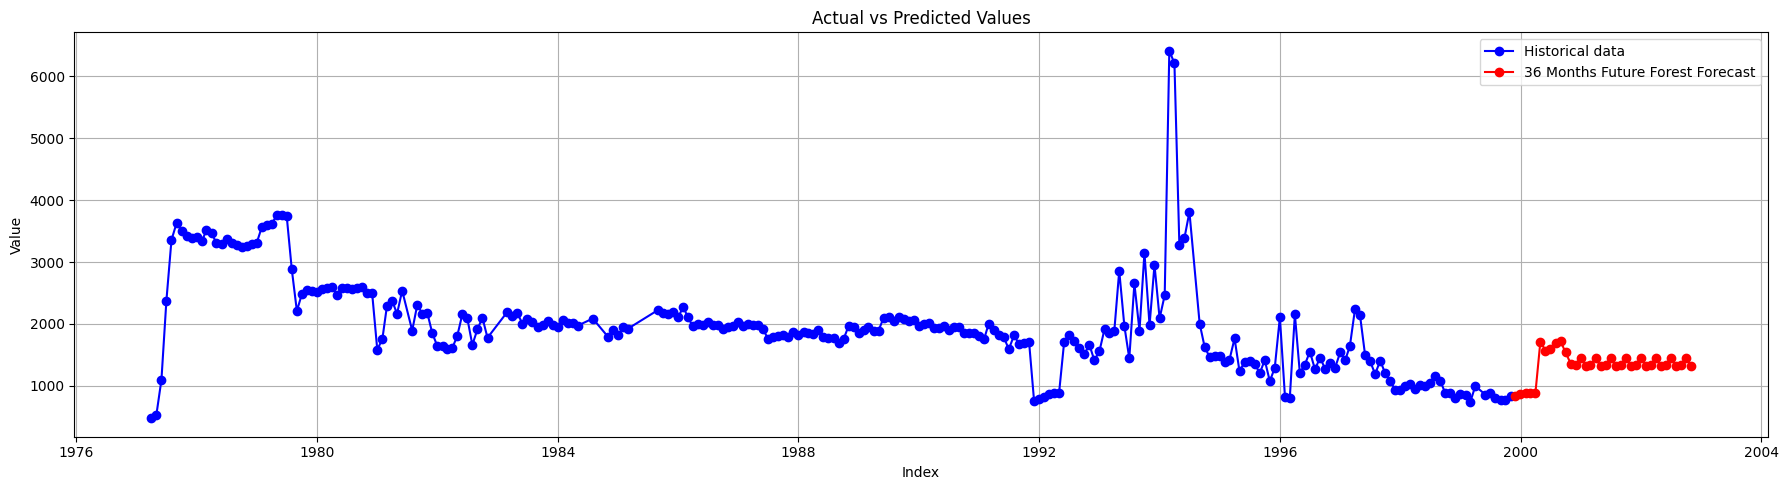

In [156]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(18, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Historical data', marker='o')
#plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(future_ds, future_forcast, color='r', label=f'{PERIODS} Months Future Forest Forecast', marker='o')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()